# Imports

In [4]:
# imports

import os
import numpy as np
import random
import pandas as pd
import json
import datetime
import pickle
import matplotlib.pyplot as plt
from utils import *

In [11]:
# Global settings
FREQBINS = 25
SIGMA = 25

# From EDA
ROWS = 256
COLS = 256

# Control runtime
run_retrain = True
display_orig_filt_images = False

# Import and split data

In [12]:
# define file directory
directory = '../data/interim/PatternNet/PatternNet/images'

# create a list of all possible classes
all_classes = []
for item in os.listdir(directory):
    item_path = os.path.join(directory, item)
    if os.path.isdir(item_path):
        all_classes.append(item)
#print(all_classes)
        
# create a list of classes considered for this project
classes = ['beach', 'chaparral', 'dense_residential', 'forest', 'freeway', 'harbor', 'overpass', 'parking_space', 'river', 'swimming_pool']
        
# inspect the number of images per class
data = []
for class_name in classes:
    class_dir = os.path.join(directory, class_name)
    image_count = len(os.listdir(class_dir))
    data.append([class_name, image_count])
image_count_df = pd.DataFrame(data, columns=['Class', 'Total Image Count'])
print("The following classes were selected for evaluation:")
display(image_count_df)

# define the train, val, and test sets
train_files, val_files, test_files = generate_splits(classes, directory)

The following classes were selected for evaluation:


,Class,Total Image Count
0,beach,800
1,chaparral,800
2,dense_residential,800
3,forest,800
4,freeway,800
5,harbor,800
6,overpass,800
7,parking_space,800
8,river,800
9,swimming_pool,800


train/validation/test subsets were loaded from a pre-generated file
	Number of train files: 4799
	Number of val files: 1599
	Number of test files: 1601


# Utility functions

In [13]:
def create_dataframe(histogram_bins):
    fixed_column_names = ['class_name', 'class_id']
    empty_df = pd.DataFrame(columns=fixed_column_names)

    # Additional column names generated using list comprehension
    bin_names = [f'Bin_{i}' for i in range(1, histogram_bins + 1)] 

    # Add the additional columns to the empty DataFrame
    for column_name in bin_names:
        empty_df[column_name] = None  # Add the column with None values

    # Display the resulting DataFrame
    return (empty_df)


In [14]:
# define a function to run spectrum images in a directory (given a file subset)
# The function runs a FFT analysis on all training files 
def generate_freq_spectrum(files, directory, images_per_class=3):
    # create a dictionary to store class images
    class_images = {}
    
    # iterate over each file
    for class_name, file_name in files:
        # load the image
        img = plt.imread(os.path.join(directory, class_name, file_name))
        # if class not in dictionary, initialize empty list
        if class_name not in class_images:
            class_images[class_name] = []
        # append image to class list
        class_images[class_name].append(img)

    # create a grid of images
    count = 0
    pd1 = create_dataframe(histogram_bins=FREQBINS)
    pd2 = create_dataframe(histogram_bins=FREQBINS)
    filt = create_gaussian_filter(ROWS, COLS, SIGMA)
    
    num_classes = len(class_images)
    for i, (class_name, images) in enumerate(class_images.items()):
        # display random images in the subsequent columns
        random.shuffle(images)
        for j in range(images_per_class):
            magnitude_spectrum = fft_image(images[j])
            spec = np.log(1+magnitude_spectrum).ravel()
            
            hist, bins = np.histogram(spec, bins=FREQBINS) 
            hist1_df = pd.DataFrame([hist], columns=[f'Bin_{i}' for i in range(1, len(hist) + 1)], dtype=int)
            hist1_df['class_name'] = class_name
            hist1_df['class_id'] = i

            filtered_image = apply_gaussian_filter(images[j], filt)

            magnitude_spectrum = fft_image(filtered_image)
            spec = np.log(1+magnitude_spectrum).ravel()
            
            hist, bins = np.histogram(spec, bins=FREQBINS) 
            hist2_df = pd.DataFrame([hist], columns=[f'Bin_{i}' for i in range(1, len(hist) + 1)], dtype=int)
            hist2_df['class_name'] = class_name
            hist2_df['class_id'] = i
            
            count += 1
            
            pd1 = pd.concat([pd1, hist1_df], ignore_index=True)
            pd2 = pd.concat([pd2, hist2_df], ignore_index=True)
    
    return pd1, pd2

In [15]:
# define a function to show a grid of spectrum images in a directory (given a file subset)
def display_orig_filtered_image(files, directory, images_per_class=3, sigma=SIGMA):
    # create a dictionary to store class images
    class_images = {}
    
    # iterate over each file
    for class_name, file_name in files:
        # load the image
        img = plt.imread(os.path.join(directory, class_name, file_name))
        # if class not in dictionary, initialize empty list
        if class_name not in class_images:
            class_images[class_name] = []
        # append image to class list
        class_images[class_name].append(img)

    # create a grid of images
    filt = create_filter(ROWS, COLS, sigma)
    
    num_classes = len(class_images)
    fig, axes = plt.subplots(num_classes, (images_per_class + 1), figsize=(12, 3*num_classes))
    for i, (class_name, images) in enumerate(class_images.items()):
        #display class name in the first column
        axes[i, 0].text(0.5, 0.5, class_name, fontsize=16, ha='center', va='center')
        axes[i, 0].axis('off')

        # display random images in the subsequent columns
        random.shuffle(images)
        for j in range(images_per_class):
            magnitude_spectrum1 = fft_image(images[j])
            spec = np.log(1+magnitude_spectrum1).ravel()
            
            filtered_image = apply_gaussian_filter(images[j], filt)
            magnitude_spectrum2 = fft_image(filtered_image)
            spec = np.log(1+magnitude_spectrum2).ravel()
            
            #axes[i, j+1].imshow(images[j], cmap='gray')
            axes[i, j+1].imshow(filtered_image, cmap='gray')


    plt.tight_layout()
    plt.show()

    return

## main function to control execution

In [16]:
if run_retrain is True:
    start_time = datetime.datetime.now()
    unfilt_train_df, filt_train_df = generate_freq_spectrum(train_files, directory, images_per_class=450)
    end_time = datetime.datetime.now()

    # Calculate the elapsed time
    elapsed_time = end_time - start_time
    print("Time taken for training:", elapsed_time)

if display_orig_filt_images:
    display_orig_filtered_image(train_files, directory, images_per_class=1, sigma=SIGMA)

Time taken for training: 0:01:53.659454


Save both filtered and unfiltered dataframes for future analysis

In [17]:
csv_name = f'freq_spec_no_filt_bins_{FREQBINS}.csv'
directory = '../data/processed/'
file = directory + csv_name
unfilt_train_df.to_csv(directory+csv_name, index=False)

csv_name = f'freq_spec_lpf_{SIGMA}_bins_{FREQBINS}.csv'
directory = '../data/processed/'
file = directory + csv_name
filt_train_df.to_csv(directory+csv_name, index=False)

## Slice and Dice on training data
Peek-poke and summarise training data - filtered/unfiltered.

In [18]:
grouped_df = filt_train_df.loc[:,'class_id':'Bin_25'].groupby('class_id')
summary_df = grouped_df.agg(['mean'])
print(summary_df)

              Bin_1      Bin_2       Bin_3        Bin_4        Bin_5  \
               mean       mean        mean         mean         mean   
class_id                                                               
0         18.288889  70.248889  273.877778   960.737778  3184.513333   
1         17.502222  71.217778  278.724444   994.417778  3381.895556   
2         15.446667  53.848889  187.340000   615.522222  1925.764444   
3         16.720000  66.726667  254.008889   907.686667  3022.044444   
4         19.235556  77.086667  282.300000   951.635556  3023.973333   
5         16.115556  62.471111  230.542222   804.437778  2643.642222   
6         17.608889  68.624444  262.751111   941.562222  3133.526667   
7         18.126667  69.011111  263.708889   932.840000  3124.137778   
8         17.515556  71.911111  282.122222  1022.811111  3464.317778   
9         16.753333  62.762222  231.966667   794.153333  2572.284444   

                 Bin_6         Bin_7         Bin_8         Bin_

In [19]:
#filt_train_df.loc[0:4, 'class_name': 'Bin_10']

In [20]:
#filt_train_df.loc[0:2, 'Bin_1': 'Bin_20'].plot(kind='bar', legend=False)
#plt.xlabel(filt_train_df.columns[0])
#plt.ylabel('Frequency')
#plt.title('Histogram from DataFrame with Bins as Columns')
#plt.show()


In [21]:
#filt_train_df.loc[:,'class_id':'Bin_14']

## Run prediction models on test data
Try Random forest and KNN on training data

In [22]:
# Splitting arrays or matrices into random train and test subsets
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics, svm
from sklearn.neighbors import KNeighborsClassifier

shuffled_df = filt_train_df.sample(frac=1).reset_index(drop=True)

X = shuffled_df.loc[:, 'Bin_5': 'Bin_20']
y = shuffled_df['class_name']

# i.e. 70 % training dataset and 30 % test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30)

# creating a RF classifier
clf = RandomForestClassifier(n_estimators = 100, max_depth=10)  
 
# Training the model on the training dataset
# fit function is used to train the model using the training sets as parameters
clf.fit(X_train, y_train)
 
# performing predictions on the test dataset
y_pred = clf.predict(X_test)

# using metrics module for accuracy calculation
print("Accuracy of RF model:", metrics.accuracy_score(y_test, y_pred))

# Create KNN classifier
knn = KNeighborsClassifier(n_neighbors = 3)# Fit the classifier to the data
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

print('Accuracy of KNN model: ', knn.score(X_test, y_test))

poly = svm.SVC(kernel='poly', C=5, decision_function_shape='ovr').fit(X_train, y_train)
poly_pred = poly.predict(X_test)

print('Accuracy of SVM model: ', poly.score(X_test, y_test))

Accuracy of RF model: 0.8555555555555555
Accuracy of KNN model:  0.7214814814814815
Accuracy of SVM model:  0.7837037037037037


## PCA
See which features (bins) are of importance 

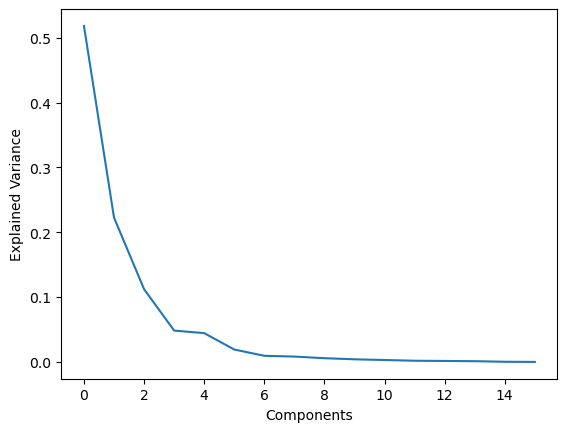

             PC0       PC1       PC2       PC3       PC4       PC5       PC6  \
Bin_5   0.229067 -0.362987  0.100419  0.242316 -0.088171 -0.126400 -0.255139   
Bin_6   0.241877 -0.364350  0.101661  0.155157 -0.031991 -0.046667 -0.078702   
Bin_7   0.265585 -0.307129  0.043221 -0.158333  0.129629  0.162911  0.393370   
Bin_8  -0.121429  0.422433 -0.213711 -0.409891  0.159177  0.117243  0.123317   
Bin_9  -0.188913  0.393844 -0.020979  0.334289 -0.172818 -0.190318 -0.393909   
Bin_10 -0.199965  0.200365  0.287988  0.643121 -0.047630  0.078221  0.487641   
Bin_11 -0.230725 -0.028350  0.451789  0.009627  0.352695  0.405174  0.065086   
Bin_12 -0.253053 -0.088813  0.421844 -0.144229  0.255669  0.048368 -0.302760   
Bin_13 -0.280032 -0.120732  0.319649 -0.215036  0.047826 -0.303235 -0.152126   
Bin_14 -0.298818 -0.150300  0.157946 -0.205053 -0.183616 -0.378739  0.129598   
Bin_15 -0.302546 -0.170543 -0.009346 -0.121011 -0.328623 -0.195759  0.262800   
Bin_16 -0.295646 -0.190116 -0.124183 -0.

In [23]:
from sklearn.decomposition import PCA

df = filt_train_df.loc[:, 'Bin_5': 'Bin_20']

# You must normalize the data before applying the fit method
df_normalized=(df - df.mean()) / df.std()
pca = PCA(n_components=df.shape[1])
pca.fit(df_normalized)

plt.plot(pca.explained_variance_ratio_)
plt.ylabel('Explained Variance')
plt.xlabel('Components')
plt.show()


# Reformat and view results
loadings = pd.DataFrame(pca.components_.T,
columns=['PC%s' % _ for _ in range(len(df_normalized.columns))],
index=df.columns)
print(loadings)




In [24]:
dictbin = {}
for i in loadings.columns:
    k = loadings.sort_values(by=[i])
    bincount = 0
    for bins in k.index:
        bincount += 1
        if bincount == 10:
            break
        if bins in dictbin:
            dictbin[bins] += 1
        else:
            dictbin[bins] = 0

sorted_by_values= sorted(dictbin.items(), key=lambda x: x[1], reverse=True)

# Print the sorted dictionary
for key, value in sorted_by_values:
    print(key, value)

Bin_17 11
Bin_18 11
Bin_20 10
Bin_15 9
Bin_16 9
Bin_13 9
Bin_6 9
Bin_12 8
Bin_11 8
Bin_5 8
Bin_14 7
Bin_9 7
Bin_19 6
Bin_7 6
Bin_8 6
Bin_10 4


In [25]:
# Use this codeblock to read from pre-trained data
if not run_retrain:
    csv_name = f'freq_spec_lpf_{SIGMA}_bins_{FREQBINS}.csv'
    directory = '../data/processed/'
    file = directory + csv_name
    filt_train_df = pd.read_csv(directory+csv_name)
    
    csv_name = f'freq_spec_no_filt_bins_{FREQBINS}.csv'
    directory = '../data/processed/'
    file = directory + csv_name
    unfilt_train_df = pd.read_csv(directory+csv_name)